In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style='ticks', context='talk')
pd.set_option('use_inf_as_na', True)
pd.options.display.max_columns=200
pd.options.display.max_rows=300

In [2]:
from patchseq_utils import plotting as plot, regressions as reg, shiny, analysis as utils

In [3]:
from patchseq_utils import l1_load, util, analysis as utils
from importlib import reload
reload(l1_load)
reload(util)

<module 'patchseq_utils.util' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/util.py'>

In [4]:
from patchseq_utils.l1_load import *
from patchseq_utils.util import *

# L1 type definitions

In [5]:
def plot_fractions_l1(inh_df, cluster, layer='layer', cutoff=0.02):
    proportions = inh_df[inh_df[layer].notna() & inh_df[layer].str.contains('1')][cluster].value_counts(normalize=True)
    proportions.name = 'Fraction of L1'
    df = proportions.loc[lambda df: df>cutoff]
    plt.figure(figsize=(4,3))
    sns.pointplot(x=df, y=df.index, join=False)
    plt.xlim(0,None)
    return proportions
    
def plot_proportion_l1(inh_df, cluster, layer='layer', cutoff=0.1, l1_factor=1, fillna=True):
    if fillna:
        inh_df = inh_df.copy()
        inh_df[layer] = inh_df[layer].fillna('')
    proportions = inh_df[inh_df[layer].notna()].groupby(cluster).apply(
        lambda df: df[layer].str.contains('1').sum() * l1_factor / 
        ((~df[layer].str.contains('1')).sum() + df[layer].str.contains('1').sum() * l1_factor) ).sort_values(ascending=False)
    proportions.name = 'Proportion of type in L1'
    df = proportions.loc[lambda df: df>cutoff]
    plt.figure(figsize=(4,3))
    sns.pointplot(x=df, y=df.index, join=False)
    plt.xlim(0,None)
    return proportions

def plot_proportion_layer(inh_df, cluster, l, layer='layer', cutoff=0.1, l1_factor=1, fillna=True):
    if fillna:
        inh_df = inh_df.copy()
        inh_df[layer] = inh_df[layer].fillna('')
    proportions = inh_df[inh_df[layer].notna()].groupby(cluster).apply(
        lambda df: df[layer].str.contains(l).sum() * l1_factor / 
        ((~df[layer].str.contains(l)).sum() + df[layer].str.contains('1').sum() * l1_factor) ).sort_values(ascending=False)
    proportions.name = f'Proportion of type in L{l}'
    df = proportions.loc[lambda df: df>cutoff]
    plt.figure(figsize=(4,3))
    sns.pointplot(x=df, y=df.index, join=False)
    plt.xlim(0,None)
    return proportions

In [6]:
thickness = [235, 295, 405, 370, 285, 552, 480]
density = [8333, 45563, 20964, 15090, 46167, 23076, 26774]
ref_counts = np.array(thickness) * np.array(density)
ref_counts = np.array([*ref_counts[:2], ref_counts[2:4].sum(), *ref_counts[4:]])

### FACS

In [7]:
facs_dir = "/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev"
facs_df = shiny.load_shiny_data(None, directory=facs_dir, drop_offpipeline=False, nms_pass=False)


In [8]:
facs_df.groupby('external_donor_name').apply(lambda df: df.loc[
    lambda df: ~df.layer.str.contains('-'), 'layer']
                            .unique())
             # .value_counts(normalize=True, sort=True))

external_donor_name
H16.03.004                        [L5]
H16.06.002                        [L5]
H16.06.008                        [L5]
H16.06.009                        [L5]
H16.24.010    [L1, L2, L3, L4, L5, L6]
H200.1023     [L1, L4, L5, L2, L3, L6]
H200.1025     [L1, L5, L2, L4, L6, L3]
H200.1030     [L5, L4, L2, L3, L6, L1]
dtype: object

In [9]:
donors = ['H16.24.010', 'H200.1023', 'H200.1025', 'H200.1030']
facs_df = facs_df.loc[lambda df: 
                      df.external_donor_name.isin(donors)]
inh_df = facs_df.loc[facs_df['max.leaf.class']=='GABAergic']
human_facs = inh_df.copy()
human_facs[cluster] = human_facs['cluster'].map(shorten_name)

In [10]:
counts = facs_df.layer.value_counts(normalize=True).sort_index().rename('facs').to_frame()
counts['defelipe'] = ref_counts / ref_counts.sum()
counts

,facs,defelipe
L1,0.070385,0.028705
L2,0.139302,0.197025
L3,0.228901,0.206299
L4,0.189472,0.192870
L5,0.193275,0.186718
L6,0.178664,0.188383


In [11]:
counts['facs'].iloc[2:4].sum() / counts['defelipe'].iloc[2:4].sum()

1.0481128627678278

Most counts match well if L1 dissection includes ~30% of L2 (despite stated oversampling of L1 and L6 also)

LAMP5 NMBR        0.314993
ADARB2 MC4R       0.107290
SST BAGE2         0.089409
PAX6 CDH12        0.085282
SST CHRNA4        0.066025
LAMP5 LCP2        0.063274
VIP PCDH20        0.045392
VIP TSPAN12       0.035763
VIP LBH           0.034388
LAMP5 DBP         0.023384
VIP ADAMTSL1      0.020633
VIP CHRM2         0.017882
SST CALB1         0.017882
PVALB WFDC2       0.012380
VIP SYT6          0.011004
LAMP5 CA1         0.011004
PAX6 TNFAIP8L3    0.009629
VIP GGH           0.006878
Name: Fraction of L1, dtype: float64

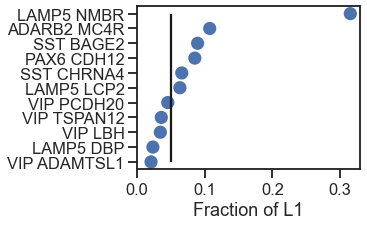

In [12]:
df = human_facs
frac = plot_fractions_l1(df, cluster)
plt.vlines(0.05, 0, 10, 'k')
save_plot_multiple(figdir/"s1_l1_frac_human", ['pdf','svg'])

frac.head(18)

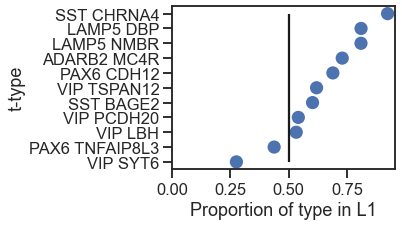

In [13]:
# prop = plot_proportion_l1(df, cluster, l1_factor=0.7)
prop = plot_proportion_l1(df, cluster, l1_factor=1, cutoff=0.25)
plt.vlines(0.5, 0, 10, 'k')
save_plot_multiple(figdir/"s1_l1_prop_human", ['pdf','svg'])

In [14]:
df = frac.rename('frac').to_frame().join(prop.rename('prop'))
df.loc[(df.frac>0.05) | (df.prop>0.4)]

,frac,prop
LAMP5 NMBR,0.314993,0.809187
ADARB2 MC4R,0.107290,0.728972
SST BAGE2,0.089409,0.601852
PAX6 CDH12,0.085282,0.688889
SST CHRNA4,0.066025,0.923077
LAMP5 LCP2,0.063274,0.133721
VIP PCDH20,0.045392,0.540984
VIP TSPAN12,0.035763,0.619048
VIP LBH,0.034388,0.531915
LAMP5 DBP,0.023384,0.809524


In [15]:
# missing TNFAIP, adds SYT6, ADAMTS, LBH
list(frac.head(15).index.intersection(prop.head(15).index))

['LAMP5 NMBR',
 'ADARB2 MC4R',
 'SST BAGE2',
 'PAX6 CDH12',
 'SST CHRNA4',
 'LAMP5 LCP2',
 'VIP PCDH20',
 'VIP TSPAN12',
 'VIP LBH',
 'LAMP5 DBP',
 'VIP ADAMTSL1',
 'VIP SYT6']

### PS

In [16]:
shiny_human = get_full_human_metadata_df() #get_shiny('human')
ps_df = shiny_human.join(human_depth, lsuffix="_shiny")
ps_df['target_layer'] = shiny_human.roi.fillna('').apply(get_num)

df = ps_df.query('tx_qc').copy()
cluster='topLeaf'

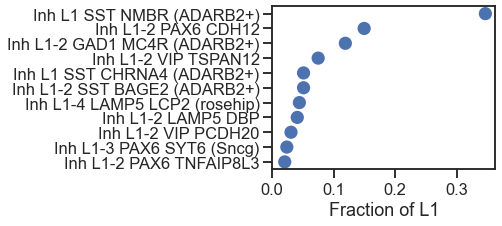

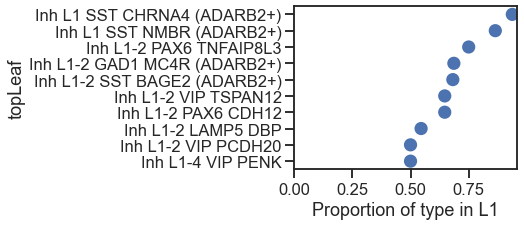

In [17]:
frac = plot_fractions_l1(df, cluster, layer='target_layer')


prop = plot_proportion_l1(df, cluster, layer='target_layer', 
                          l1_factor=1, cutoff=0.4, fillna=True)

In [18]:
# set cutoff at 3%
frac.head(15)

Inh L1 SST NMBR (ADARB2+)             0.346939
Inh L1-2 PAX6 CDH12                   0.149660
Inh L1-2 GAD1 MC4R (ADARB2+)          0.119048
Inh L1-2 VIP TSPAN12                  0.074830
Inh L1 SST CHRNA4 (ADARB2+)           0.051020
Inh L1-2 SST BAGE2 (ADARB2+)          0.051020
Inh L1-4 LAMP5 LCP2 (rosehip)         0.044218
Inh L1-2 LAMP5 DBP                    0.040816
Inh L1-2 VIP PCDH20                   0.030612
Inh L1-3 PAX6 SYT6 (Sncg)             0.023810
Inh L1-2 PAX6 TNFAIP8L3               0.020408
Inh L1-3 VIP ADAMTSL1                 0.013605
Inh L1-4 VIP CHRNA6                   0.006803
Inh L1-4 VIP PENK                     0.006803
Inh L2-5 PVALB SCUBE3 (chandelier)    0.003401
Name: Fraction of L1, dtype: float64

In [19]:
df = frac.rename('frac').to_frame().join(prop.rename('prop'))
df.loc[(df.frac>0.03) | (df.prop>0.5)]

,frac,prop
Inh L1 SST NMBR (ADARB2+),0.346939,0.864407
Inh L1-2 PAX6 CDH12,0.149660,0.647059
Inh L1-2 GAD1 MC4R (ADARB2+),0.119048,0.686275
Inh L1-2 VIP TSPAN12,0.074830,0.647059
Inh L1 SST CHRNA4 (ADARB2+),0.051020,0.937500
Inh L1-2 SST BAGE2 (ADARB2+),0.051020,0.681818
Inh L1-4 LAMP5 LCP2 (rosehip),0.044218,0.276596
Inh L1-2 LAMP5 DBP,0.040816,0.545455
Inh L1-2 VIP PCDH20,0.030612,0.500000
Inh L1-2 PAX6 TNFAIP8L3,0.020408,0.750000


In [20]:
df = ps_df.query('tx_qc').copy()

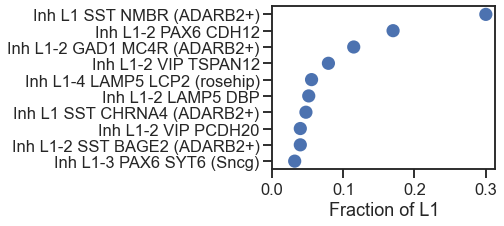

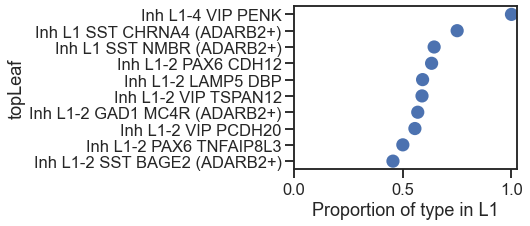

In [21]:
frac = plot_fractions_l1(df, cluster)
prop = plot_proportion_l1(df, cluster, l1_factor=1, cutoff=0.4)
# plot_proportion_l1(df, cluster, l1_factor=0.5, cutoff=0.2);

In [22]:
frac.head(15)

Inh L1 SST NMBR (ADARB2+)        0.300395
Inh L1-2 PAX6 CDH12              0.169960
Inh L1-2 GAD1 MC4R (ADARB2+)     0.114625
Inh L1-2 VIP TSPAN12             0.079051
Inh L1-4 LAMP5 LCP2 (rosehip)    0.055336
Inh L1-2 LAMP5 DBP               0.051383
Inh L1 SST CHRNA4 (ADARB2+)      0.047431
Inh L1-2 VIP PCDH20              0.039526
Inh L1-2 SST BAGE2 (ADARB2+)     0.039526
Inh L1-3 PAX6 SYT6 (Sncg)        0.031621
Inh L1-4 VIP PENK                0.015810
Inh L1-2 PAX6 TNFAIP8L3          0.015810
Inh L1-3 VIP ADAMTSL1            0.015810
Inh L2-6 LAMP5 CA1 (Igtp)        0.007905
Inh L1-2 VIP LBH                 0.007905
Name: Fraction of L1, dtype: float64

In [23]:
prop.head(15)
# PENK did not have deeper layers annotated, likely biased
#  maybe also borderline: LBH, ADAMTSL1, SYT6

topLeaf
Inh L1-4 VIP PENK                1.000000
Inh L1 SST CHRNA4 (ADARB2+)      0.750000
Inh L1 SST NMBR (ADARB2+)        0.644068
Inh L1-2 PAX6 CDH12              0.632353
Inh L1-2 LAMP5 DBP               0.590909
Inh L1-2 VIP TSPAN12             0.588235
Inh L1-2 GAD1 MC4R (ADARB2+)     0.568627
Inh L1-2 VIP PCDH20              0.555556
Inh L1-2 PAX6 TNFAIP8L3          0.500000
Inh L1-2 SST BAGE2 (ADARB2+)     0.454545
Inh L1-3 VIP ADAMTSL1            0.400000
Inh L1-4 LAMP5 LCP2 (rosehip)    0.297872
Inh L1-3 PAX6 SYT6 (Sncg)        0.296296
Inh L3-6 VIP HS3ST3A1            0.250000
Inh L1-2 VIP LBH                 0.222222
Name: Proportion of type in L1, dtype: float64

In [24]:
# confirms TNFAIP8L3, removes LBH
df = frac.rename('frac').to_frame().join(prop.rename('prop'))
df.loc[(df.frac>0.05) | (df.prop>=0.5)]

,frac,prop
Inh L1 SST NMBR (ADARB2+),0.300395,0.644068
Inh L1-2 PAX6 CDH12,0.169960,0.632353
Inh L1-2 GAD1 MC4R (ADARB2+),0.114625,0.568627
Inh L1-2 VIP TSPAN12,0.079051,0.588235
Inh L1-4 LAMP5 LCP2 (rosehip),0.055336,0.297872
Inh L1-2 LAMP5 DBP,0.051383,0.590909
Inh L1 SST CHRNA4 (ADARB2+),0.047431,0.750000
Inh L1-2 VIP PCDH20,0.039526,0.555556
Inh L1-4 VIP PENK,0.015810,1.000000
Inh L1-2 PAX6 TNFAIP8L3,0.015810,0.500000


In [25]:
list(frac.head(15).index.intersection(prop.head(15).index))

['Inh L1 SST NMBR (ADARB2+)',
 'Inh L1-2 PAX6 CDH12',
 'Inh L1-2 GAD1 MC4R (ADARB2+)',
 'Inh L1-2 VIP TSPAN12',
 'Inh L1-4 LAMP5 LCP2 (rosehip)',
 'Inh L1-2 LAMP5 DBP',
 'Inh L1 SST CHRNA4 (ADARB2+)',
 'Inh L1-2 VIP PCDH20',
 'Inh L1-2 SST BAGE2 (ADARB2+)',
 'Inh L1-3 PAX6 SYT6 (Sncg)',
 'Inh L1-4 VIP PENK',
 'Inh L1-2 PAX6 TNFAIP8L3',
 'Inh L1-3 VIP ADAMTSL1',
 'Inh L1-2 VIP LBH']

## Mouse

### FACS

In [26]:
facs_dir = "/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/Mm_VISp_AIT2.3.0_20047_202005"
facs_df = shiny.load_shiny_data(None, directory=facs_dir, drop_offpipeline=False, nms_pass=False)
facs_df = facs_df[facs_df['class']=="GABAergic"]

In [27]:
genotypes = [
    "Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt",
    "Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt",
    "Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt"
]
slices = [f"CR00{x}" for x in [3,4,5,6,7]]
df = facs_df.loc[lambda df: df['genotype'].isin(genotypes)
                & df['slice'].isin(slices)
                ]
mouse_facs = df

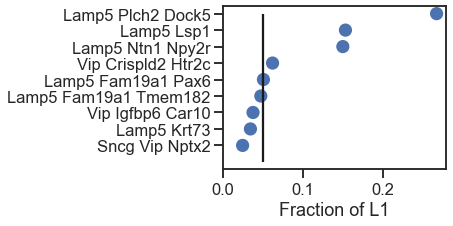

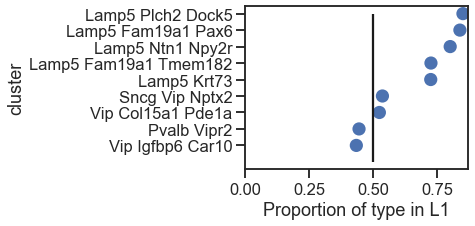

In [28]:
cluster='cluster'
frac = plot_fractions_l1(df, cluster, layer='layer', cutoff=0.02)
plt.vlines(0.05, 0, 9, 'k')
save_plot_multiple(figdir/"s1_l1_frac_mouse", ['pdf','svg'])

prop = plot_proportion_l1(df, cluster, layer='layer', l1_factor=1., cutoff=0.4)
plt.vlines(0.5, 0, 9, 'k')
save_plot_multiple(figdir/"s1_l1_prop_mouse", ['pdf','svg'])

# plot_proportion_l1(df, cluster, l1_factor=0.5, cutoff=0.2);

### PS

In [29]:
# mostly targeted, not possible to restrict to pan-inh
mouse_df.query("layer=='1'").genotype.value_counts(normalize=True)

Ndnf-IRES2-dgCre/wt;Ai14(RCL-tdT)/wt                           0.338028
Ndnf-IRES2-dgCre/wt;Slc32a1-IRES2-FlpO/wt;Ai65(RCFL-tdT)/wt    0.323944
Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt                              0.084507
Sncg-IRES2-FlpO-neo/wt;Ai65F/wt                                0.070423
Cck-IRES-Cre/wt;Vip-IRES-FlpO/wt;Ai65(RCFL-tdT)/wt             0.056338
Htr3a-Cre_NO152/wt;Ai14(RCL-tdT)/wt                            0.056338
Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt                           0.042254
Oxtr-T2A-Cre/wt;Ai14(RCL-tdT)/wt                               0.014085
Chrna2-Cre_OE25/wt;Ai14(RCL-tdT)/wt                            0.014085
Name: genotype, dtype: float64

In [55]:
# mostly targeted, not possible to restrict to pan-inh
mouse_df.query("layer_ccf=='1'").genotype.value_counts(normalize=True)

Ndnf-IRES2-dgCre/wt;Ai14(RCL-tdT)/wt                           0.368664
Ndnf-IRES2-dgCre/wt;Slc32a1-IRES2-FlpO/wt;Ai65(RCFL-tdT)/wt    0.276498
Htr3a-Cre_NO152/wt;Ai14(RCL-tdT)/wt                            0.078341
Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt                              0.059908
Sncg-IRES2-FlpO-neo/wt;Ai65F/wt                                0.059908
Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt                           0.055300
Cck-IRES-Cre/wt;Vip-IRES-FlpO/wt;Ai65(RCFL-tdT)/wt             0.032258
Nos1-CreERT2/wt;Ai14(RCL-tdT)/wt                               0.023041
Oxtr-T2A-Cre/wt;Ai14(RCL-tdT)/wt                               0.018433
Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt                               0.009217
Glt25d2-Cre_NF107/wt;Ai14(RCL-tdT)/wt                          0.009217
Slc32a1-IRES2-FlpO/wt;Ai65F/wt                                 0.004608
Vip-IRES-Cre/wt;Npy-IRES2-FlpO/wt;Ai65(RCFL-tdT)/wt            0.004608
Name: genotype, dtype: float64

In [30]:
# from l1_init - need to get non-L1 types
shiny_mouse = get_shiny('mouse')

# this filter or offpipeline (project code MET)
shiny_mouse = shiny_mouse.loc[
    lambda df:  
    (df['collection'] == "Patch-seq Production") &
    df['project_code'].isin(['mIVSCC-MET', 'mIVSCC-METx']) 
    & df.structure.str.contains('VIS') 
]
shiny_mouse['target_layer'] = shiny_mouse.layer.fillna('').apply(get_num)
shiny_mouse.drop(columns=['layer'], inplace=True)

shiny_mouse['layer_ccf'] = shiny_mouse['structure'].fillna('').apply(get_num)

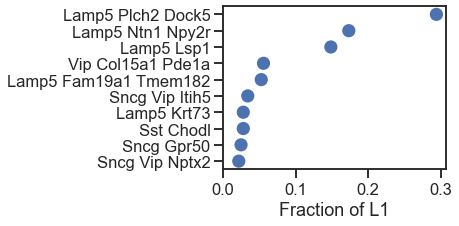

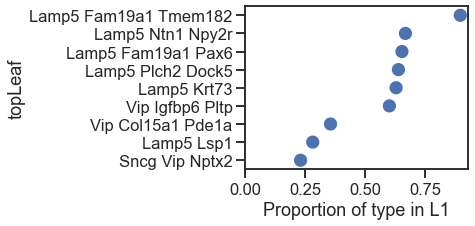

In [31]:
df = shiny_mouse
cluster='topLeaf'
layer='layer_ccf'
# layer='layer_lims'
frac = plot_fractions_l1(df, cluster, layer=layer, cutoff=0.02)
prop = plot_proportion_l1(df, cluster, layer=layer, l1_factor=1.5, cutoff=0.2)
# plot_proportion_l1(df, cluster, l1_factor=0.5, cutoff=0.2);

In [32]:
frac.head(10)

Lamp5 Plch2 Dock5        0.294118
Lamp5 Ntn1 Npy2r         0.173375
Lamp5 Lsp1               0.148607
Vip Col15a1 Pde1a        0.055728
Lamp5 Fam19a1 Tmem182    0.052632
Sncg Vip Itih5           0.034056
Lamp5 Krt73              0.027864
Sst Chodl                0.027864
Sncg Gpr50               0.024768
Sncg Vip Nptx2           0.021672
Name: Fraction of L1, dtype: float64

In [33]:
df = frac.rename('frac').to_frame().join(prop.rename('prop'))
df.loc[(df.frac>0.05) | (df.prop>0.5)]
# have to go down to prop<0.25 or combine types to include Sncg

,frac,prop
Lamp5 Plch2 Dock5,0.294118,0.637584
Lamp5 Ntn1 Npy2r,0.173375,0.666667
Lamp5 Lsp1,0.148607,0.281250
Vip Col15a1 Pde1a,0.055728,0.355263
Lamp5 Fam19a1 Tmem182,0.052632,0.894737
Lamp5 Krt73,0.027864,0.627907
Lamp5 Fam19a1 Pax6,0.015480,0.652174
Vip Igfbp6 Pltp,0.003096,0.600000


In [34]:
list(frac.head(15).index.intersection(prop.head(15).index))

['Lamp5 Plch2 Dock5',
 'Lamp5 Ntn1 Npy2r',
 'Lamp5 Lsp1',
 'Vip Col15a1 Pde1a',
 'Lamp5 Fam19a1 Tmem182',
 'Sncg Vip Itih5',
 'Lamp5 Krt73',
 'Sncg Gpr50',
 'Sncg Vip Nptx2',
 'Lamp5 Fam19a1 Pax6']

# L1 Proportions

## Subclass

In [38]:
cluster = 't-type'
human_facs['homology_type'] = human_facs[cluster].map(homology_mapping_human)
mouse_facs['homology_type'] = mouse_facs['cluster'].map(homology_mapping_mouse)
mouse_facs_l1 = mouse_facs.query("layer=='L1'").copy()
human_facs_l1 = human_facs.query("layer=='L1'").copy()
mouse_facs_l1[cluster] = mouse_facs_l1['cluster'].astype(ttypes_mouse)
human_facs_l1[cluster] = human_facs_l1[cluster].astype(ttypes_human)

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())


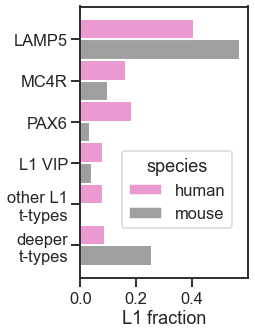

In [40]:
data = pd.concat([human_df.query('strict_l1'), mouse_facs_l1.assign(species='mouse')], sort=False)
other = 'other L1\nt-types'
deep = 'deeper\nt-types'
data.homology_type = data.homology_type.replace('other', other)
data.homology_type = data.homology_type.fillna(deep)
long_subclasses = CategoricalDtype(categories=['LAMP5', 'MC4R', 'PAX6', 'L1 VIP', other, deep],
                                   ordered=True)
data.homology_type = data.homology_type.astype(long_subclasses)
fig, ax = plt.subplots(figsize=(3,5))
sns.histplot(data=data, y='homology_type', hue='species', palette=species_palette, ax=ax, 
             multiple='dodge', stat='probability', common_norm=False)
l = ax.get_legend().set_bbox_to_anchor([0.2, 0.5])
# sns.displot(data=combined, y='homology_type', hue='species', palette=species_palette, ax=ax)
ax.set_ylabel(None)
ax.set_xlabel('L1 fraction')
# save_plot_multiple(figdir/"f1_proportions", ['pdf','svg'])

In [41]:
utils.fisher_test_all(data, meta='species', cluster='homology_type', fdr_method='fdr_bh')

PAX6                 7.872188e-12
other L1\nt-types    3.550695e-11
deeper\nt-types      1.239539e-08
LAMP5                2.037039e-05
MC4R                 1.216186e-02
L1 VIP               4.397943e-02
dtype: float64

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())


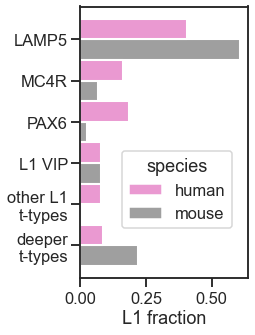

In [82]:
shiny_mouse_l1 = shiny_mouse.query("layer_ccf=='1' | layer_lims=='1'")
shiny_mouse_l1['homology_type'] = shiny_mouse_l1[cluster].map(homology_mapping_mouse)
data = pd.concat([human_df.query('strict_l1'), shiny_mouse_l1.assign(species='mouse')], sort=False)
other = 'other L1\nt-types'
deep = 'deeper\nt-types'
data.homology_type = data.homology_type.replace('other', other)
data.homology_type = data.homology_type.fillna(deep)
long_subclasses = CategoricalDtype(categories=['LAMP5', 'MC4R', 'PAX6', 'L1 VIP', other, deep], ordered=True)
data.homology_type = data.homology_type.astype(long_subclasses)
fig, ax = plt.subplots(figsize=(3,5))
sns.histplot(data=data, y='homology_type', hue='species', palette=species_palette, ax=ax, 
             multiple='dodge', stat='probability', common_norm=False)
l = ax.get_legend().set_bbox_to_anchor([0.2, 0.5])
ax.set_ylabel(None)
ax.set_xlabel('L1 fraction')
save_plot_multiple(figdir/"f1_proportions", ['pdf','svg'])

In [79]:
utils.fisher_test_all(data, meta='species', cluster='homology_type', fdr_method='fdr_bh')

PAX6                 2.789127e-10
other L1\nt-types    8.790734e-08
LAMP5                3.807222e-06
deeper\nt-types      1.473970e-05
MC4R                 5.231111e-04
L1 VIP               1.000000e+00
dtype: float64

## human

### merfish via proportions

In [ ]:
merfish = pd.read_csv("../data/merfish_proportions.csv", header=None)
merfish[0] = merfish[0].apply(shorten_name).apply(lambda x: x if x in l1_types_human else 'other')
merfish = merfish.groupby(0).sum()[1]/100

In [ ]:
other_cat = pd.CategoricalDtype(categories=l1_types_human.to_list()+['other'], ordered=True)
def prop_transform(df): 
    df[cluster] = df[cluster].astype(other_cat)
    res = df[cluster].fillna('other').value_counts(normalize=True).rename('fraction').reset_index()
    return res
ps = human_df.query("layer=='1'").copy().pipe(prop_transform)
facs = human_facs_l1.copy().pipe(prop_transform)
mfish = merfish.rename('fraction').to_frame().reset_index()
mfish['index'] = mfish[0].astype(ps['index'].dtype)

[Text(0, 0, 'LAMP5 LCP2'),
 Text(1, 0, 'LAMP5 DBP'),
 Text(2, 0, 'LAMP5 NMBR'),
 Text(3, 0, 'SST CHRNA4'),
 Text(4, 0, 'ADARB2 MC4R'),
 Text(5, 0, 'PAX6 CDH12'),
 Text(6, 0, 'PAX6 TNFAIP8L3'),
 Text(7, 0, 'VIP TSPAN12'),
 Text(8, 0, 'SST BAGE2'),
 Text(9, 0, 'VIP PCDH20'),
 Text(10, 0, 'other')]

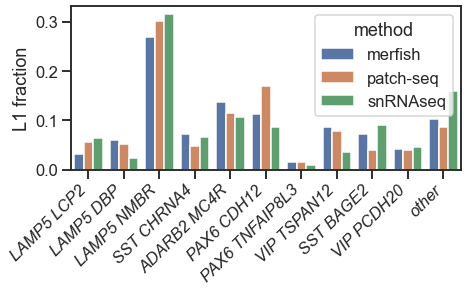

In [ ]:
y = 'fraction'
fracdata = pd.concat([mfish.assign(method='merfish'),
          ps.assign(method='patch-seq'),
           facs.assign(method='snRNAseq'),], sort=False)
fig, ax = plt.subplots(figsize=(7,3))
sns.barplot(data=fracdata, x='index', y=y, hue='method')

ax.set_xlabel(None)
ax.set_ylabel('L1 fraction')
ax.set_xticklabels(other_cat.categories, rotation=45, fontstyle='italic', ha='right')

### merfish via counts

In [88]:
other_cat = pd.CategoricalDtype(categories=l1_types_human.to_list()+['other'], ordered=True)
def fill_other(df):
    df[cluster] = df[cluster].astype(other_cat).fillna('other')
    return df

In [89]:
counts = pd.read_csv("../data/merfish_counts.csv", index_col=0).reset_index()

counts[cluster] = counts['index'].apply(shorten_name)
mfish_samples = counts[cluster].loc[counts.index.repeat(counts['total'])]
mfish = mfish_samples.rename(cluster).to_frame().pipe(fill_other).assign(method='MERFISH')
ps = human_df.query("layer=='1'").copy().pipe(fill_other).assign(method="patch-seq")
facs = human_facs_l1.copy().pipe(fill_other).assign(method='snRNA-seq')

In [90]:
data = pd.concat([ps, facs, mfish], sort=False)
data['method'].value_counts()

snRNA-seq    727
MERFISH      600
patch-seq    253
Name: method, dtype: int64

In [91]:
p_ps_facs = utils.fisher_test_all(pd.concat([ps, facs], sort=False), meta='method', cluster=cluster)
p_ps_facs

PAX6 CDH12        0.003868
other             0.024272
VIP TSPAN12       0.024375
SST BAGE2         0.024375
LAMP5 DBP         0.073683
SST CHRNA4        0.661842
PAX6 TNFAIP8L3    0.766882
LAMP5 NMBR        0.837369
ADARB2 MC4R       0.837369
LAMP5 LCP2        0.837369
VIP PCDH20        0.858685
dtype: float64

In [92]:
p_ps_mfish = utils.fisher_test_all(pd.concat([ps, mfish], sort=False), meta='method', cluster=cluster)
p_ps_mfish

LAMP5 LCP2        0.185688
PAX6 CDH12        0.185688
SST CHRNA4        0.233873
SST BAGE2         0.233873
LAMP5 NMBR        0.233873
other             0.282067
LAMP5 DBP         0.693444
ADARB2 MC4R       0.788041
VIP PCDH20        0.880009
VIP TSPAN12       0.978103
PAX6 TNFAIP8L3    1.000000
dtype: float64

In [93]:
p_facs_mfish = utils.fisher_test_all(pd.concat([facs, mfish], sort=False), meta='method', cluster=cluster)
p_facs_mfish

LAMP5 DBP         0.001281
LAMP5 LCP2        0.002602
VIP TSPAN12       0.005140
LAMP5 NMBR        0.019490
other             0.127673
PAX6 CDH12        0.174275
ADARB2 MC4R       0.294259
PAX6 TNFAIP8L3    0.294259
SST CHRNA4        0.294259
SST BAGE2         0.294259
VIP PCDH20        0.795683
dtype: float64

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


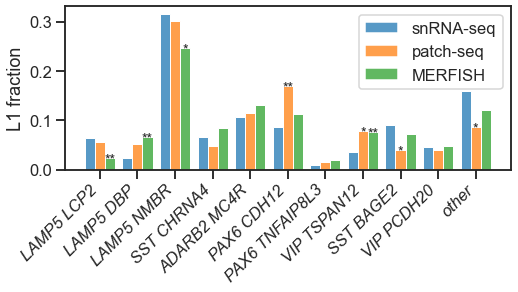

In [94]:
fig, ax = plt.subplots(figsize=(8,3))
sns.histplot(data=data, x=cluster, hue='method', ax=ax, 
             multiple='dodge', stat='probability', common_norm=False, zorder=0, shrink=0.8,
             hue_order=[ 'snRNA-seq',  'patch-seq', 'MERFISH'],
            palette={'snRNA-seq':'tab:blue', 'patch-seq':'tab:orange', 'MERFISH':'tab:green'})
l = ax.get_legend()
l.set_title(None)
                  
types = other_cat.categories
ax.set_xlabel(None)
ax.set_ylabel('L1 fraction')
ax.set_xticklabels(types, rotation=45, fontstyle='italic', ha='right')

for j, p in enumerate(ax.patches):
    i_method, i_type = j//len(types), j%len(types)
    if i_method==1:
        pval = p_ps_facs[types[i_type]]
    elif i_method==0:
        pval = p_facs_mfish[types[i_type]]
    else: continue
    h, w, x, y = p.get_height(), p.get_width(), p.get_x(), p.get_y()
    text = np.choose(np.searchsorted([1e-3, 1e-2, 5e-2], pval), ['***','**','*',''])
    ax.annotate(text=text, xy=(x+w/2, h+0.01), ha='center', va='top', size=14)
    
save_plot_multiple(figdir/"s1_l1_fractions", ['pdf','svg'])

## mouse

In [84]:
other_cat = pd.CategoricalDtype(categories=l1_types_mouse.to_list()+['other'], ordered=True)
def fill_other(df):
    df[cluster] = df[cluster].astype(other_cat).fillna('other')
    return df

In [85]:
ps = shiny_mouse_l1.copy().pipe(fill_other).assign(method="patch-seq")
facs = mouse_facs_l1.copy().pipe(fill_other).assign(method='snRNA-seq')

data = pd.concat([ps, facs], sort=False)
data['method'].value_counts()

snRNA-seq    613
patch-seq    336
Name: method, dtype: int64

In [86]:
p_mouse = utils.fisher_test_all(data, meta='method', cluster=cluster)
p_mouse

Vip Col15a1 Pde1a        0.015236
Lamp5 Fam19a1 Pax6       0.030485
other                    0.802561
Lamp5 Plch2 Dock5        0.924057
Lamp5 Ntn1 Npy2r         0.924057
Lamp5 Krt73              0.924676
Lamp5 Fam19a1 Tmem182    0.924676
Sncg Vip Nptx2           0.924676
Lamp5 Lsp1               0.924676
dtype: float64

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


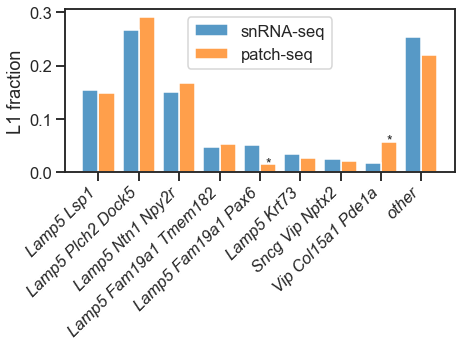

In [87]:
# data = pd.concat([mouse_l1.assign(method="patch-seq"), 
#                   mouse_facs_l1.loc[lambda df: df[cluster].isin(l1_types_mouse)].assign(method='snRNA-seq')],
#                   sort=False)

fig, ax = plt.subplots(figsize=(7,3))
sns.histplot(data=data, x=cluster, hue='method', ax=ax, 
             multiple='dodge', stat='probability', common_norm=False, 
             zorder=0, shrink=0.8,
            palette={'snRNA-seq':'tab:blue', 'patch-seq':'tab:orange'},
             hue_order=[ 'snRNA-seq',  'patch-seq',],)
l = ax.get_legend()
l.set_title(None)
# sns.displot(data=combined, y='homology_type', hue='species', palette=species_palette, ax=ax)
types = other_cat.categories
ax.set_xlabel(None)
ax.set_ylabel('L1 fraction')
ax.set_xticklabels(types, rotation=45, fontstyle='italic', ha='right')
# dx = np.array([-0.3, 0.3])
# utils.plot_sig_bar(pval=0.04, y=0.07, x_pair=4+dx, ax=ax)
for j, p in enumerate(ax.patches):
    i_method, i_type = j//len(types), j%len(types)
    if i_method==0:
        pval = p_mouse[types[i_type]]
    else: continue
    h, w, x, y = p.get_height(), p.get_width(), p.get_x(), p.get_y()
    text = np.choose(np.searchsorted([1e-3, 1e-2, 5e-2], pval), ['***','**','*',''])
    ax.annotate(text=text, xy=(x+w/2, h+0.015), ha='center', va='top', size=14)
    
save_plot_multiple(figdir/"s1_l1_fractions_mouse", ['pdf','svg'])

# Cross-area human

In [54]:
path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Nik/human_cross_areal_comparison_SSv4/Integrated_analysis/Integrated_tome_with_3_cluster_labels/human_20190626_Cross_areal"
facs_df = shiny.load_shiny_data(None, directory=path, drop_offpipeline=False, nms_pass=False)

In [55]:
cluster = "MTG_cluster"
region = "region"
layer = "layer"
areas = ['MTG', 'MOp', 'VISp']
facs_df['type'] = facs_df[cluster].map(shorten_name).map(names_update).astype(ttypes_human)
facs_df['area'] = facs_df[region].apply(lambda x: x.split('-')[0])
facs_df[layer] = facs_df[layer].astype(int)
facs_df['subclass'] = facs_df['type'].map(homology_mapping_human)

df = facs_df.loc[lambda df: df['type'].isin(l1_types_human) 
                      & df['area'].isin(areas)]

In [56]:
from scipy.stats import fisher_exact

In [57]:
data = df
results = data.groupby(['type', 'area', 'layer'], observed=False).layer.count()
results = results.reindex(pd.MultiIndex.from_product(results.index.levels), fill_value=0)
# results = results.unstack().reindex(ttypes_human.categories).loc[:,[1,2,3]].fillna(0)
l1_count_mtg = len(data.query(f"area=='MTG' & layer==1"))

records = []
for area in ['MOp','VISp']:
    l1_count = len(data.query(f"area=='{area}' & layer==1"))
    for layer in [1,2,3]:
        for ttype in l1_types_human:
            _, pval = fisher_exact(
                [results[[(ttype, 'MTG', layer), (ttype, area, layer)]].fillna(0).values, 
                 [l1_count_mtg, l1_count]])
            records.append(dict(type=ttype, area=area, layer=layer, pval=pval))
        
res = pd.DataFrame.from_records(records)

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())


In [58]:
res = pd.DataFrame.from_records(records)
res['pval'] = res.groupby('area')['pval'].transform(
    lambda x: utils.multipletests(x, method='fdr_bh')[1])
res.sort_values('pval', ascending=True).head(10)

,type,area,layer,pval
3,SST CHRNA4,MOp,1,0.002607
50,LAMP5 LCP2,VISp,3,0.009985
33,SST CHRNA4,VISp,1,0.044326
30,LAMP5 LCP2,VISp,1,0.044326
38,SST BAGE2,VISp,1,0.428632
55,PAX6 CDH12,VISp,3,0.428632
8,SST BAGE2,MOp,1,0.500300
45,PAX6 CDH12,VISp,2,0.583802
48,SST BAGE2,VISp,2,0.583802
52,LAMP5 NMBR,VISp,3,0.601815


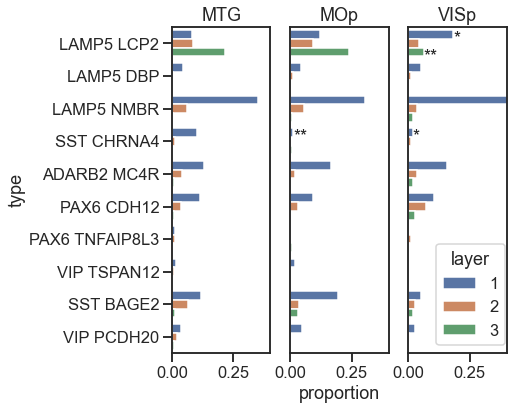

In [59]:
fig, axs = plt.subplots(1,3, figsize=(6,6))
for i, area in enumerate(areas):
    ax=axs[i]
    ax.set_title(area)
    data = df.query(f"area=='{area}'")
    l1_count = len(data.query("layer==1"))
    results = data.groupby('type', observed=True).layer.value_counts(normalize=False, dropna=False)
    results = results.unstack().reindex(ttypes_human.categories).loc[:,[1,2,3]].fillna(0) / l1_count + 0.001
    bardata = results.stack().reset_index()
    sns.barplot(data=bardata, y='type', x=0, hue='layer', ax=ax)
    if area!='MTG':
        pvals = res.query(f"area=='{area}'")['pval'].values
        for j, p in enumerate(ax.patches):
            h, w, y = p.get_height(), p.get_width(), p.get_y()
            text = np.choose(np.searchsorted([1e-3, 1e-2, 5e-2], pvals[j]), ['***','**','*',''])
            ax.annotate(text=text, xy=(w, y), ha='left', va='top')
    ax.get_legend().remove()
    ax.set_xlabel('')
    ax.set_xlim(0, 0.4)
#     ax.set_xscale('log')
#     ax.set_xlim(1e-3, 1)
#     ax.set_xticks([0.01, 0.05, 0.1, 0.25])
    if i>0:
        ax.set_yticks([])
        ax.set_ylabel('')
    if i==1:
        ax.set_xlabel('proportion')
    if i==2:
        ax.legend(bbox_to_anchor=(0.2,0), loc="lower left", title='layer')
        
# plt.savefig(figdir/"crossarea_layer_dist_human.pdf", bbox_inches='tight')
save_plot_multiple(figdir/"s1_crossarea_layer_dist_human", ['pdf','svg'])

# Cross-area mouse

In [60]:
# start here
path = "/allen/programs/celltypes/workgroups//rnaseqanalysis/shiny/facs_seq/mouse_V1_ALM_20180520/"
facs_df = shiny.load_shiny_data(None, directory=path, drop_offpipeline=False, nms_pass=False)

In [61]:
cluster = "cluster"
region = "region"
layer = "layer"
areas = ['VISp', 'ALM']
facs_df['type'] = facs_df[cluster].astype(ttypes_mouse)
facs_df['area'] = facs_df[region]
facs_df['subclass'] = facs_df['type'].map(homology_mapping_mouse)

In [62]:
facs_df.groupby('slice').apply(lambda df: df.loc[
    lambda df: ~df.layer.str.contains('-'), 'layer'].unique())

slice
CR001                        [L6, L4]
CR002                    [L5, L6, L1]
CR003          [L2/3, L4, L5, L6, L1]
CR004     [L2/3, L4, L6, L1, L5, L6b]
CR005     [L5, L6, L2/3, L4, L1, L6b]
CR006          [L1, L5, L6, L2/3, L4]
CR007          [L6, L1, L5, L2/3, L4]
CR008                  [L4, L2/3, L5]
CRVISp                          [L6b]
RC001                        [L1, L6]
RC002              [L1, L6, L2/3, L5]
RC003              [L1, L6, L5, L2/3]
RC004         [L5, L6, L2/3, L1, L6b]
RC005              [L5, L6, L2/3, L1]
RC006         [L2/3, L5, L6, L1, L6b]
RC007         [L5, L2/3, L6, L1, L6b]
RC008                  [L2/3, L6, L5]
RC009                  [L2/3, L1, L5]
RCALM                              []
dtype: object

In [63]:
l1_df = facs_df.loc[lambda df: df['type'].isin(l1_types_mouse) ]
l1_df.loc[lambda df: df.cluster.str.contains('Krt73'), 'genotype'].value_counts(normalize=True)

Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt          0.352941
Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt       0.352941
Slc17a8-IRES2-Cre/wt;Ai14(RCL-tdT)/wt      0.102941
Rasgrf2-T2A-dgFlpO/wt;Ai65F(RCF-tdT)/wt    0.058824
Slc17a8-iCre/wt;Ai14(RCL-tdT)/wt           0.044118
Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt       0.044118
Htr3a-Cre_NO152/wt;Ai14(RCL-tdT)/wt        0.029412
Chat-IRES-Cre-neo/wt;Ai14(RCL-tdT)/wt      0.014706
Name: genotype, dtype: float64

In [64]:
genotypes = [
    "Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt",
    "Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt",
    "Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt"
]

slices = ([f"CR00{x}" for x in [3,4,5,6,7]] +
          [f"RC00{x}" for x in [2,3,4,5,6,7,9]])
df = l1_df.loc[lambda df: df['genotype'].isin(genotypes)
                & df['slice'].isin(slices)
                ]

In [65]:
data = df
results = data.groupby(['type', 'area', 'layer'], observed=False).layer.count()
results = results.reindex(pd.MultiIndex.from_product(results.index.levels), fill_value=0)

l1_count_mtg = len(data.query(f"area=='VISp' & layer=='L1'"))

records = []
for area in ['ALM']:
    l1_count = len(data.query(f"area=='{area}' & layer=='L1'"))
    for layer in ['L1', 'L2/3']:
        for ttype in l1_types_mouse:
            _, pval = fisher_exact(
                [results[[(ttype, 'VISp', layer), (ttype, area, layer)]].fillna(0).values, 
                 [l1_count_mtg, l1_count]])
            records.append(dict(type=ttype, area=area, layer=layer, pval=pval))
        
res = pd.DataFrame.from_records(records)

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/dtypes/missing.py:277: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  vec = libmissing.isnaobj_old(values.ravel())


In [66]:
res = pd.DataFrame.from_records(records)
res['pval'] = res.groupby('area')['pval'].transform(
    lambda x: utils.multipletests(x, method='fdr_bh')[1])
res.sort_values('pval', ascending=True).head(10)

,type,area,layer,pval
3,Lamp5 Fam19a1 Tmem182,ALM,L1,0.047879
8,Lamp5 Lsp1,ALM,L2/3,0.121580
9,Lamp5 Plch2 Dock5,ALM,L2/3,0.517222
11,Lamp5 Fam19a1 Tmem182,ALM,L2/3,0.702443
15,Vip Col15a1 Pde1a,ALM,L2/3,0.702443
2,Lamp5 Ntn1 Npy2r,ALM,L1,0.779385
1,Lamp5 Plch2 Dock5,ALM,L1,0.963280
4,Lamp5 Fam19a1 Pax6,ALM,L1,0.963280
5,Lamp5 Krt73,ALM,L1,0.963280
6,Sncg Vip Nptx2,ALM,L1,0.963280


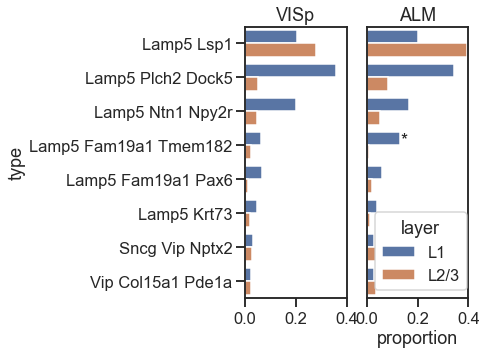

In [67]:
fig, axs = plt.subplots(1,2, figsize=(4,5))
for i, area in enumerate(areas):
    ax=axs[i]
    ax.set_title(area)
    data = df.query(f"area=='{area}'")
    l1_count = len(data.query("layer=='L1'"))
    results = data.groupby('type', observed=True).layer.value_counts(normalize=False, dropna=False)
    results = results.unstack().reindex(ttypes_mouse.categories).loc[:,['L1','L2/3']].fillna(0) / l1_count
    bardata = results.stack().reset_index()
    sns.barplot(data=bardata, y='type', x=0, hue='layer', ax=ax)
    ax.get_legend().remove()
    ax.set_xlabel('')
    ax.set_xlim(0, 0.4)
    if area!='VISp':
        pvals = res.query(f"area=='{area}'")['pval'].values
        for j, p in enumerate(ax.patches):
            h, w, y = p.get_height(), p.get_width(), p.get_y()
            text = np.choose(np.searchsorted([1e-3, 1e-2, 5e-2], pvals[j]), ['***','**','*',''])
            ax.annotate(text=text, xy=(w, y), ha='left', va='top')
#     ax.set_xscale('log')
#     ax.set_xlim(1e-3, 1)
#     ax.set_xticks([0.01, 0.05, 0.1, 0.25])
    if i>0:
        ax.set_yticks([])
        ax.set_ylabel('')
    if i==1:
        ax.set_xlabel('proportion')
        ax.legend(title='layer')

# plt.savefig(figdir/"crossarea_layer_dist_mouse.pdf", bbox_inches='tight')
save_plot_multiple(figdir/"s1_crossarea_layer_dist_mouse", ['pdf','svg'])